# Recursive Feature Elimination(RFE)

**递归特征消除**：
反复构建模型，每次迭代移除最不重要的特征，直到达到所需的特征数量。


In [20]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
current_path = os.getcwd()

# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path))


In [21]:
# Load data (assuming you have dft_train_X, dft_train_y)
file_dir = os.path.join(current_path, './Data')
# Load dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_train_set.csv'))
dft_all_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_all_train_y = dft_train['band_gap']
dft_all_train_X.shape, dft_all_train_y.shape

((8275, 132), (8275,))

In [22]:
# 从dft_train_X中抽取出一份验证集
mp_unique_comp = dft_train['composition'].unique()
len(mp_unique_comp)

8244

In [23]:
import random
# 从mp_unique_comp中随机采样组成
random.seed(RANDOM_SEED)
random_index = random.sample(range(len(mp_unique_comp)), round(dft_train.shape[0]*0.2))
mp_val_comp = mp_unique_comp[random_index]
dft_train_set = dft_train[~dft_train['composition'].isin(mp_val_comp)]
dft_val_set = dft_train[dft_train['composition'].isin(mp_val_comp)]
print(f'MP训练集大小：{len(dft_train_set)}')
print(f'MP验证集大小：{len(dft_val_set)}')

MP训练集大小：6614
MP验证集大小：1661


In [24]:
# Prepare data
dft_train_X = dft_train_set.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train_set['band_gap']
# 
dft_val_X = dft_val_set.drop(columns=['composition', 'band_gap'])
dft_val_y = dft_val_set['band_gap']

dft_train_X.shape, dft_train_y.shape, dft_val_X.shape, dft_val_y.shape

((6614, 132), (6614,), (1661, 132), (1661,))

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [26]:
# 为加快运行速度，自己实现RFE
def custom_rfe(model, X, y, X_val, y_val, target_features, step=1, verbose=True):
    """
    自定义递归特征消除函数
    """
    # 存储每一步rmse
    rmse_scores = []
    # 存储每一步选中的特征
    selected_features = []

    # 特征缩放
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    while X.shape[1] >= target_features:
        # 训练模型
        model.fit(X, y)
        
        # 获取特征重要性
        importances = model.feature_importances_
        
        # 获取特征索引
        feature_indices = np.argsort(importances)[::-1]
        # 
        selected_features.append(X.columns[feature_indices])
        
        # 在验证集上进行预测
        y_pred = model.predict(X_val)
        # 计算均方根误差 (RMSE)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
        # 打印进度
        if verbose:
            print(f"Feature nums: {X.shape[1]}, RMSE: {rmse:.4f}")

        # 删除最不重要的特征
        X = X.iloc[:, feature_indices[:-step]]
        X_val = X_val.iloc[:, feature_indices[:-step]]

    return selected_features, rmse_scores

# 使用自定义的 RFE 函数
model = RandomForestRegressor(
    n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features=0.5, random_state=RANDOM_SEED, n_jobs=-1)
selected_features, rmse_scores = custom_rfe(model, dft_train_X, dft_train_y, dft_val_X, dft_val_y, target_features=1, step=1, verbose=True)

Feature nums: 132, RMSE: 0.5593
Feature nums: 131, RMSE: 0.5563
Feature nums: 130, RMSE: 0.5559
Feature nums: 129, RMSE: 0.5575
Feature nums: 128, RMSE: 0.5589
Feature nums: 127, RMSE: 0.5588
Feature nums: 126, RMSE: 0.5581
Feature nums: 125, RMSE: 0.5604
Feature nums: 124, RMSE: 0.5569
Feature nums: 123, RMSE: 0.5570
Feature nums: 122, RMSE: 0.5574
Feature nums: 121, RMSE: 0.5556
Feature nums: 120, RMSE: 0.5556
Feature nums: 119, RMSE: 0.5563
Feature nums: 118, RMSE: 0.5579
Feature nums: 117, RMSE: 0.5598
Feature nums: 116, RMSE: 0.5566
Feature nums: 115, RMSE: 0.5553
Feature nums: 114, RMSE: 0.5582
Feature nums: 113, RMSE: 0.5571
Feature nums: 112, RMSE: 0.5541
Feature nums: 111, RMSE: 0.5583
Feature nums: 110, RMSE: 0.5596
Feature nums: 109, RMSE: 0.5552
Feature nums: 108, RMSE: 0.5597
Feature nums: 107, RMSE: 0.5611
Feature nums: 106, RMSE: 0.5592
Feature nums: 105, RMSE: 0.5566
Feature nums: 104, RMSE: 0.5601
Feature nums: 103, RMSE: 0.5609
Feature nums: 102, RMSE: 0.5566
Feature 

In [41]:
rmse_scores = rmse_scores[::-1]
selected_features = selected_features[::-1]
rmse_scores

[np.float64(0.9816277565772293),
 np.float64(0.7978487897185029),
 np.float64(0.7048863836034162),
 np.float64(0.6413187036995124),
 np.float64(0.6171105444399108),
 np.float64(0.5919167819860609),
 np.float64(0.5860399468204723),
 np.float64(0.5859460732457425),
 np.float64(0.5828172044434324),
 np.float64(0.5770244284378665),
 np.float64(0.571548453557571),
 np.float64(0.5759215347973657),
 np.float64(0.575823194664841),
 np.float64(0.5760906693930395),
 np.float64(0.5752333274366683),
 np.float64(0.570769167733256),
 np.float64(0.5719001004525959),
 np.float64(0.5652764066168006),
 np.float64(0.5669275301212814),
 np.float64(0.5659587892756378),
 np.float64(0.572047572178082),
 np.float64(0.56874381983307),
 np.float64(0.571988388860291),
 np.float64(0.5626232681781317),
 np.float64(0.5678620157941313),
 np.float64(0.5622277803087522),
 np.float64(0.5636238662977795),
 np.float64(0.5628911269493204),
 np.float64(0.5660130999414227),
 np.float64(0.5606315990767211),
 np.float64(0.566

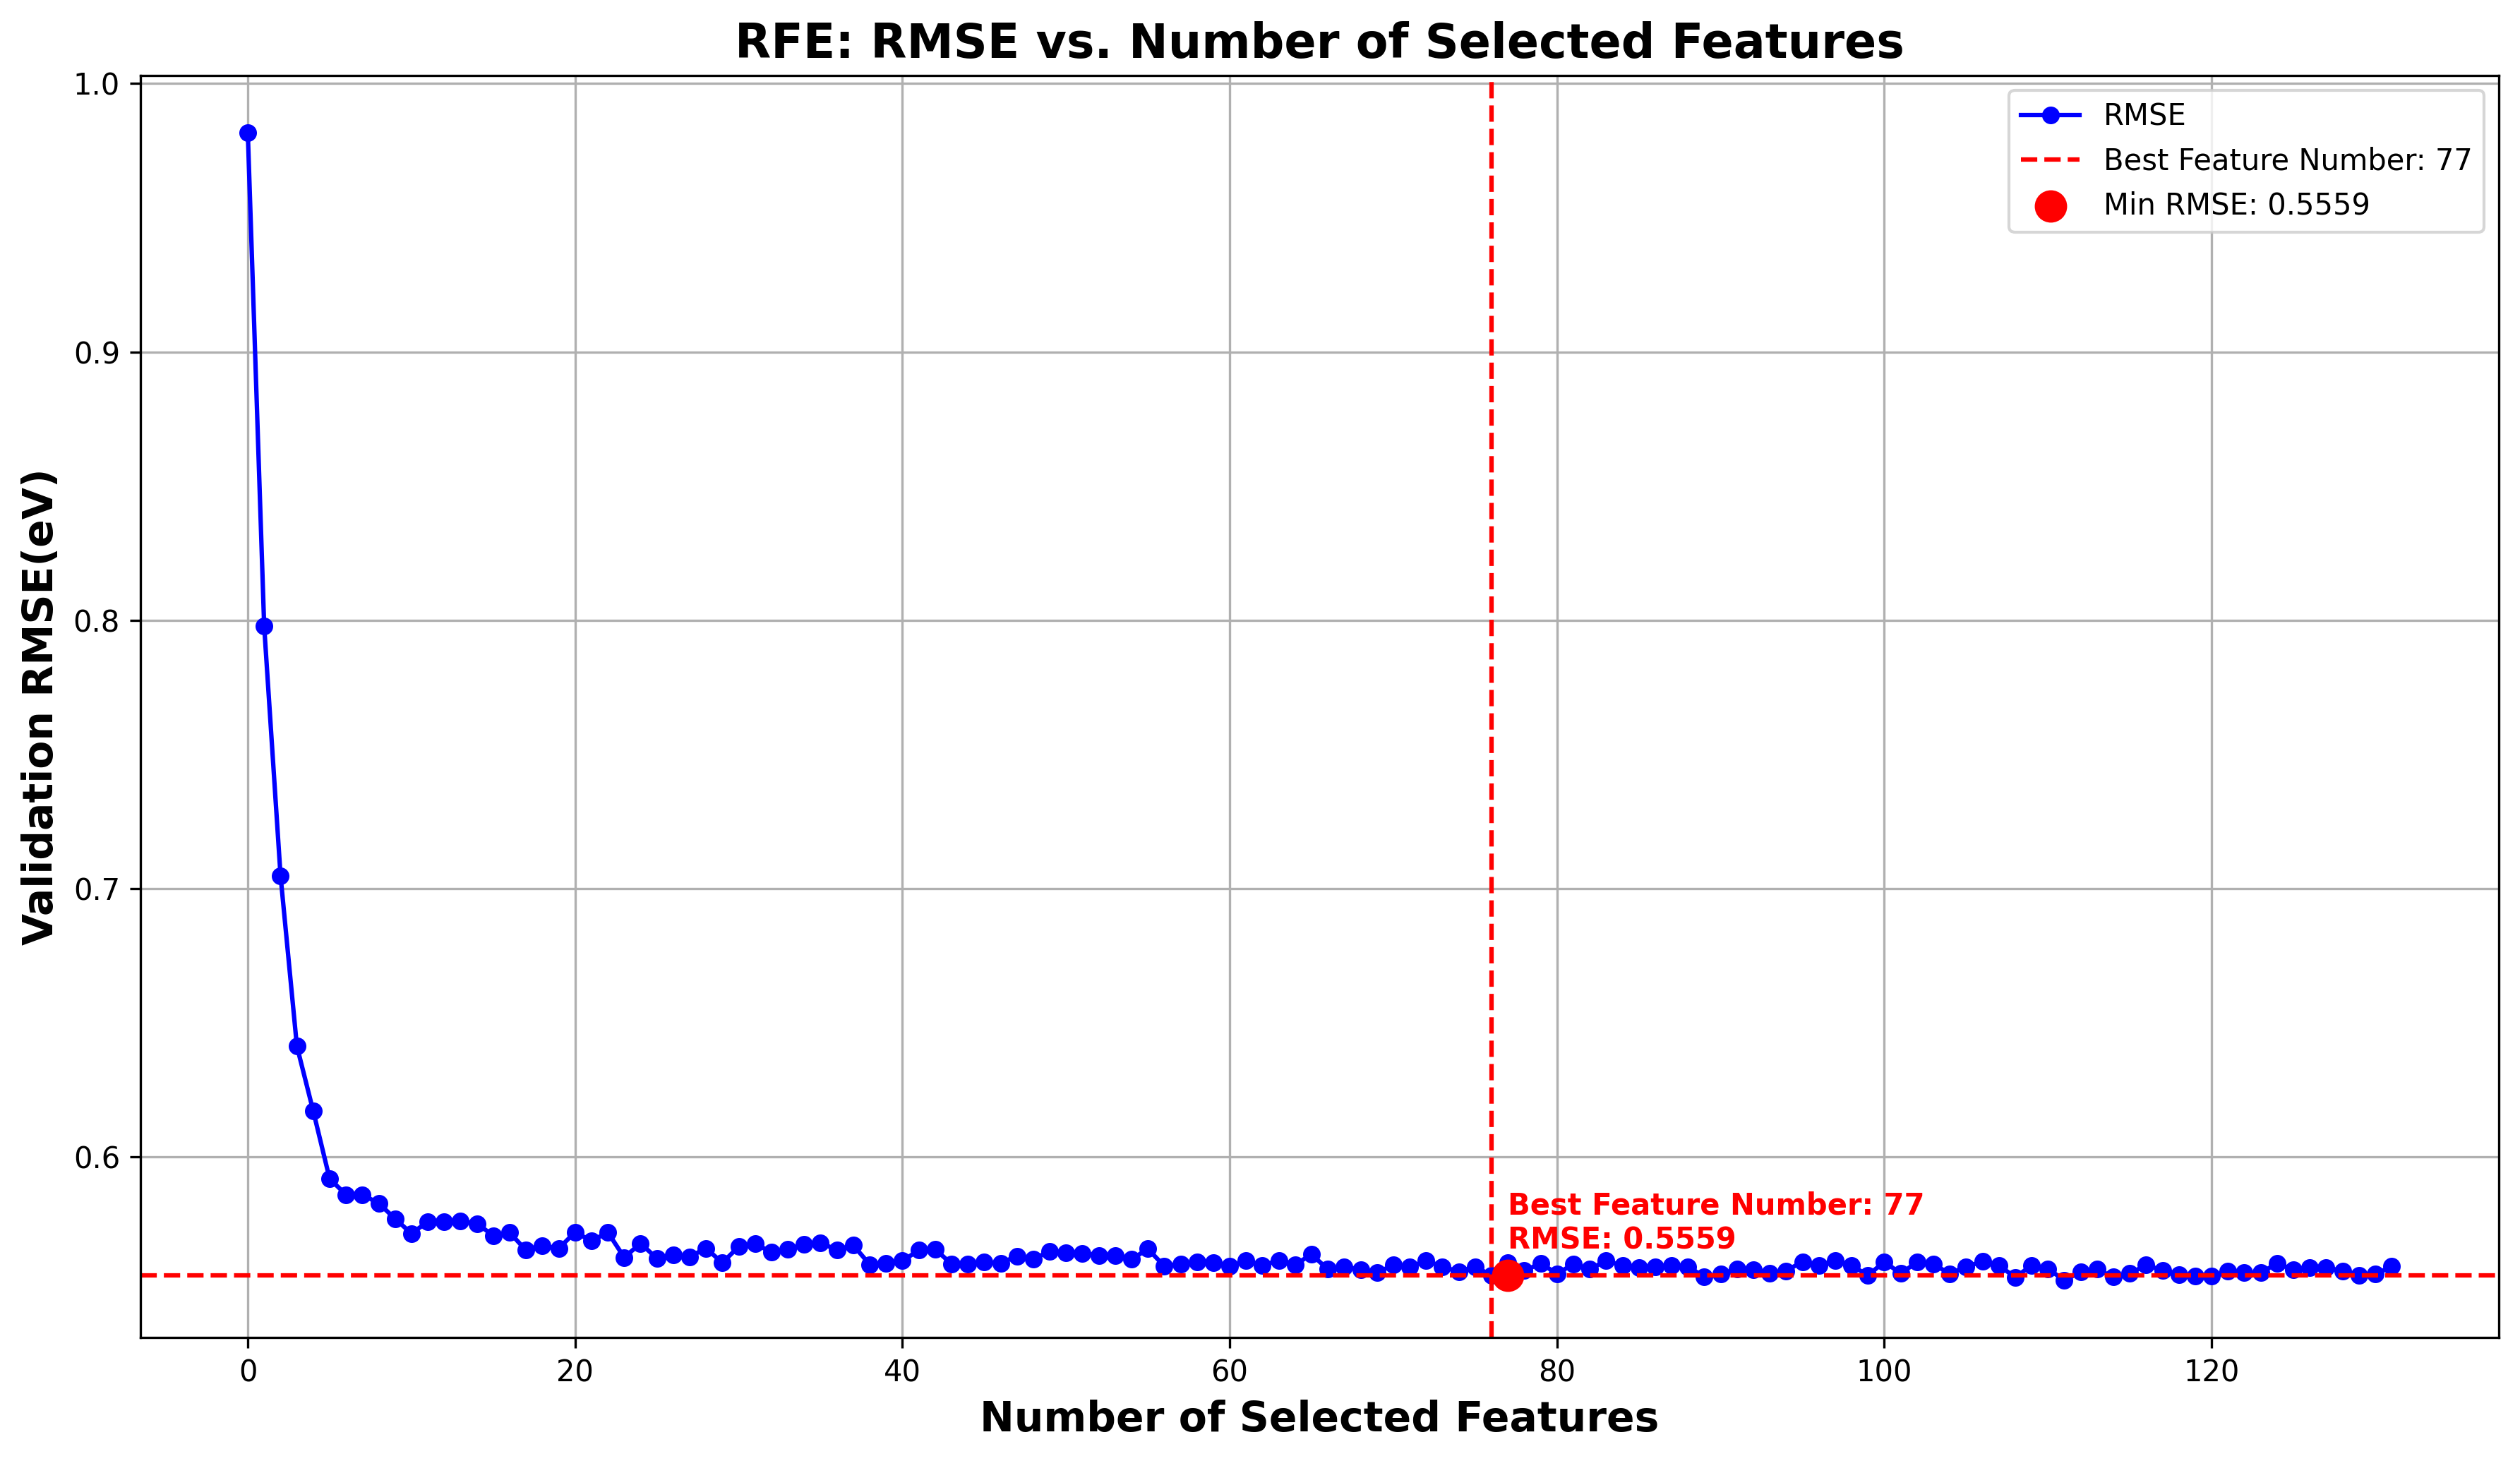


根据验证集 RMSE，最佳的特征数量是: 77
对应的最小验证集 RMSE 是: 0.5559


In [44]:
# --- 绘制 RMSE vs. 特征数量图 ---
plt.figure(figsize=(12, 7), dpi=300)
plt.plot(range(len(rmse_scores)), rmse_scores, marker='o', linestyle='-', color='blue', markersize=5, label='RMSE')
plt.xlabel('Number of Selected Features', fontsize=14, weight='bold')
plt.ylabel('Validation RMSE(eV)', fontsize=14, weight='bold')
plt.title('RFE: RMSE vs. Number of Selected Features', fontsize=16, weight='bold')
plt.grid(True)

# 在少于80个特征时找到 RMSE 最小的点
best_n_features_index = np.argmin(rmse_scores[:80])
best_n_features = best_n_features_index + 1  # +1 because index starts from 0
min_rmse = rmse_scores[best_n_features_index]

plt.axvline(x=best_n_features_index, color='red', linestyle='--', label=f'Best Feature Number: {best_n_features}')
plt.axhline(y=rmse_scores[best_n_features_index], color='red', linestyle='--')
plt.text(best_n_features_index + 1, rmse_scores[best_n_features_index] + 0.01,
         f'Best Feature Number: {best_n_features_index + 1}\nRMSE: {rmse_scores[best_n_features_index]:.4f}',
         fontsize=10, color='red', weight='bold')

plt.scatter(best_n_features, min_rmse, color='red', s=100, zorder=5,
            label=f'Min RMSE: {min_rmse:.4f}')
plt.legend(fontsize=10)
plt.tight_layout() # 调整布局防止标签重叠
fig_path = os.path.join(current_path, 'figures', 'feature_selection')
os.makedirs(fig_path, exist_ok=True)
plt.savefig(os.path.join(fig_path, 'RFE_feature_selection.png'), dpi=300)
plt.show()
print(f"\n根据验证集 RMSE，最佳的特征数量是: {best_n_features}")
print(f"对应的最小验证集 RMSE 是: {min_rmse:.4f}")

In [45]:
best_n_features

np.int64(77)

In [48]:
# 获取最佳特征集的名称
estimator_final = RandomForestRegressor(
    n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features=0.25, random_state=RANDOM_SEED, n_jobs=-1)

# 使用最佳特征数量重新训练模型
best_features = selected_features[best_n_features - 1]  # 获取最佳特征
X_train_best = dft_all_train_X.loc[:, best_features]
X_train_best = pd.DataFrame(StandardScaler().fit_transform(X_train_best), columns=X_train_best.columns)
estimator_final.fit(X_train_best, dft_all_train_y)
# 输出特征重要性
importances = estimator_final.feature_importances_
indices = np.argsort(importances)[::-1]
# 获取特征名称
feature_names = X_train_best.columns[indices]
# 保存为 DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances[indices]
})
# 保存特征重要性到 CSV 文件
save_dir = os.path.join(current_path, 'metrics', 'feature_importance', 'RFE')
os.makedirs(save_dir, exist_ok=True)
feature_importance_df.to_csv(os.path.join(save_dir, 'feature_importance.csv'), index=False)
# 保存rmse_scores
rmse_scores_df = pd.DataFrame({'RMSE': rmse_scores})
rmse_scores_df.to_csv(os.path.join(save_dir, 'rmse_scores.csv'), index=False)

Figure saved to: /workspaces/Bg_pre3/figures/feature_selection/feature_importance.png


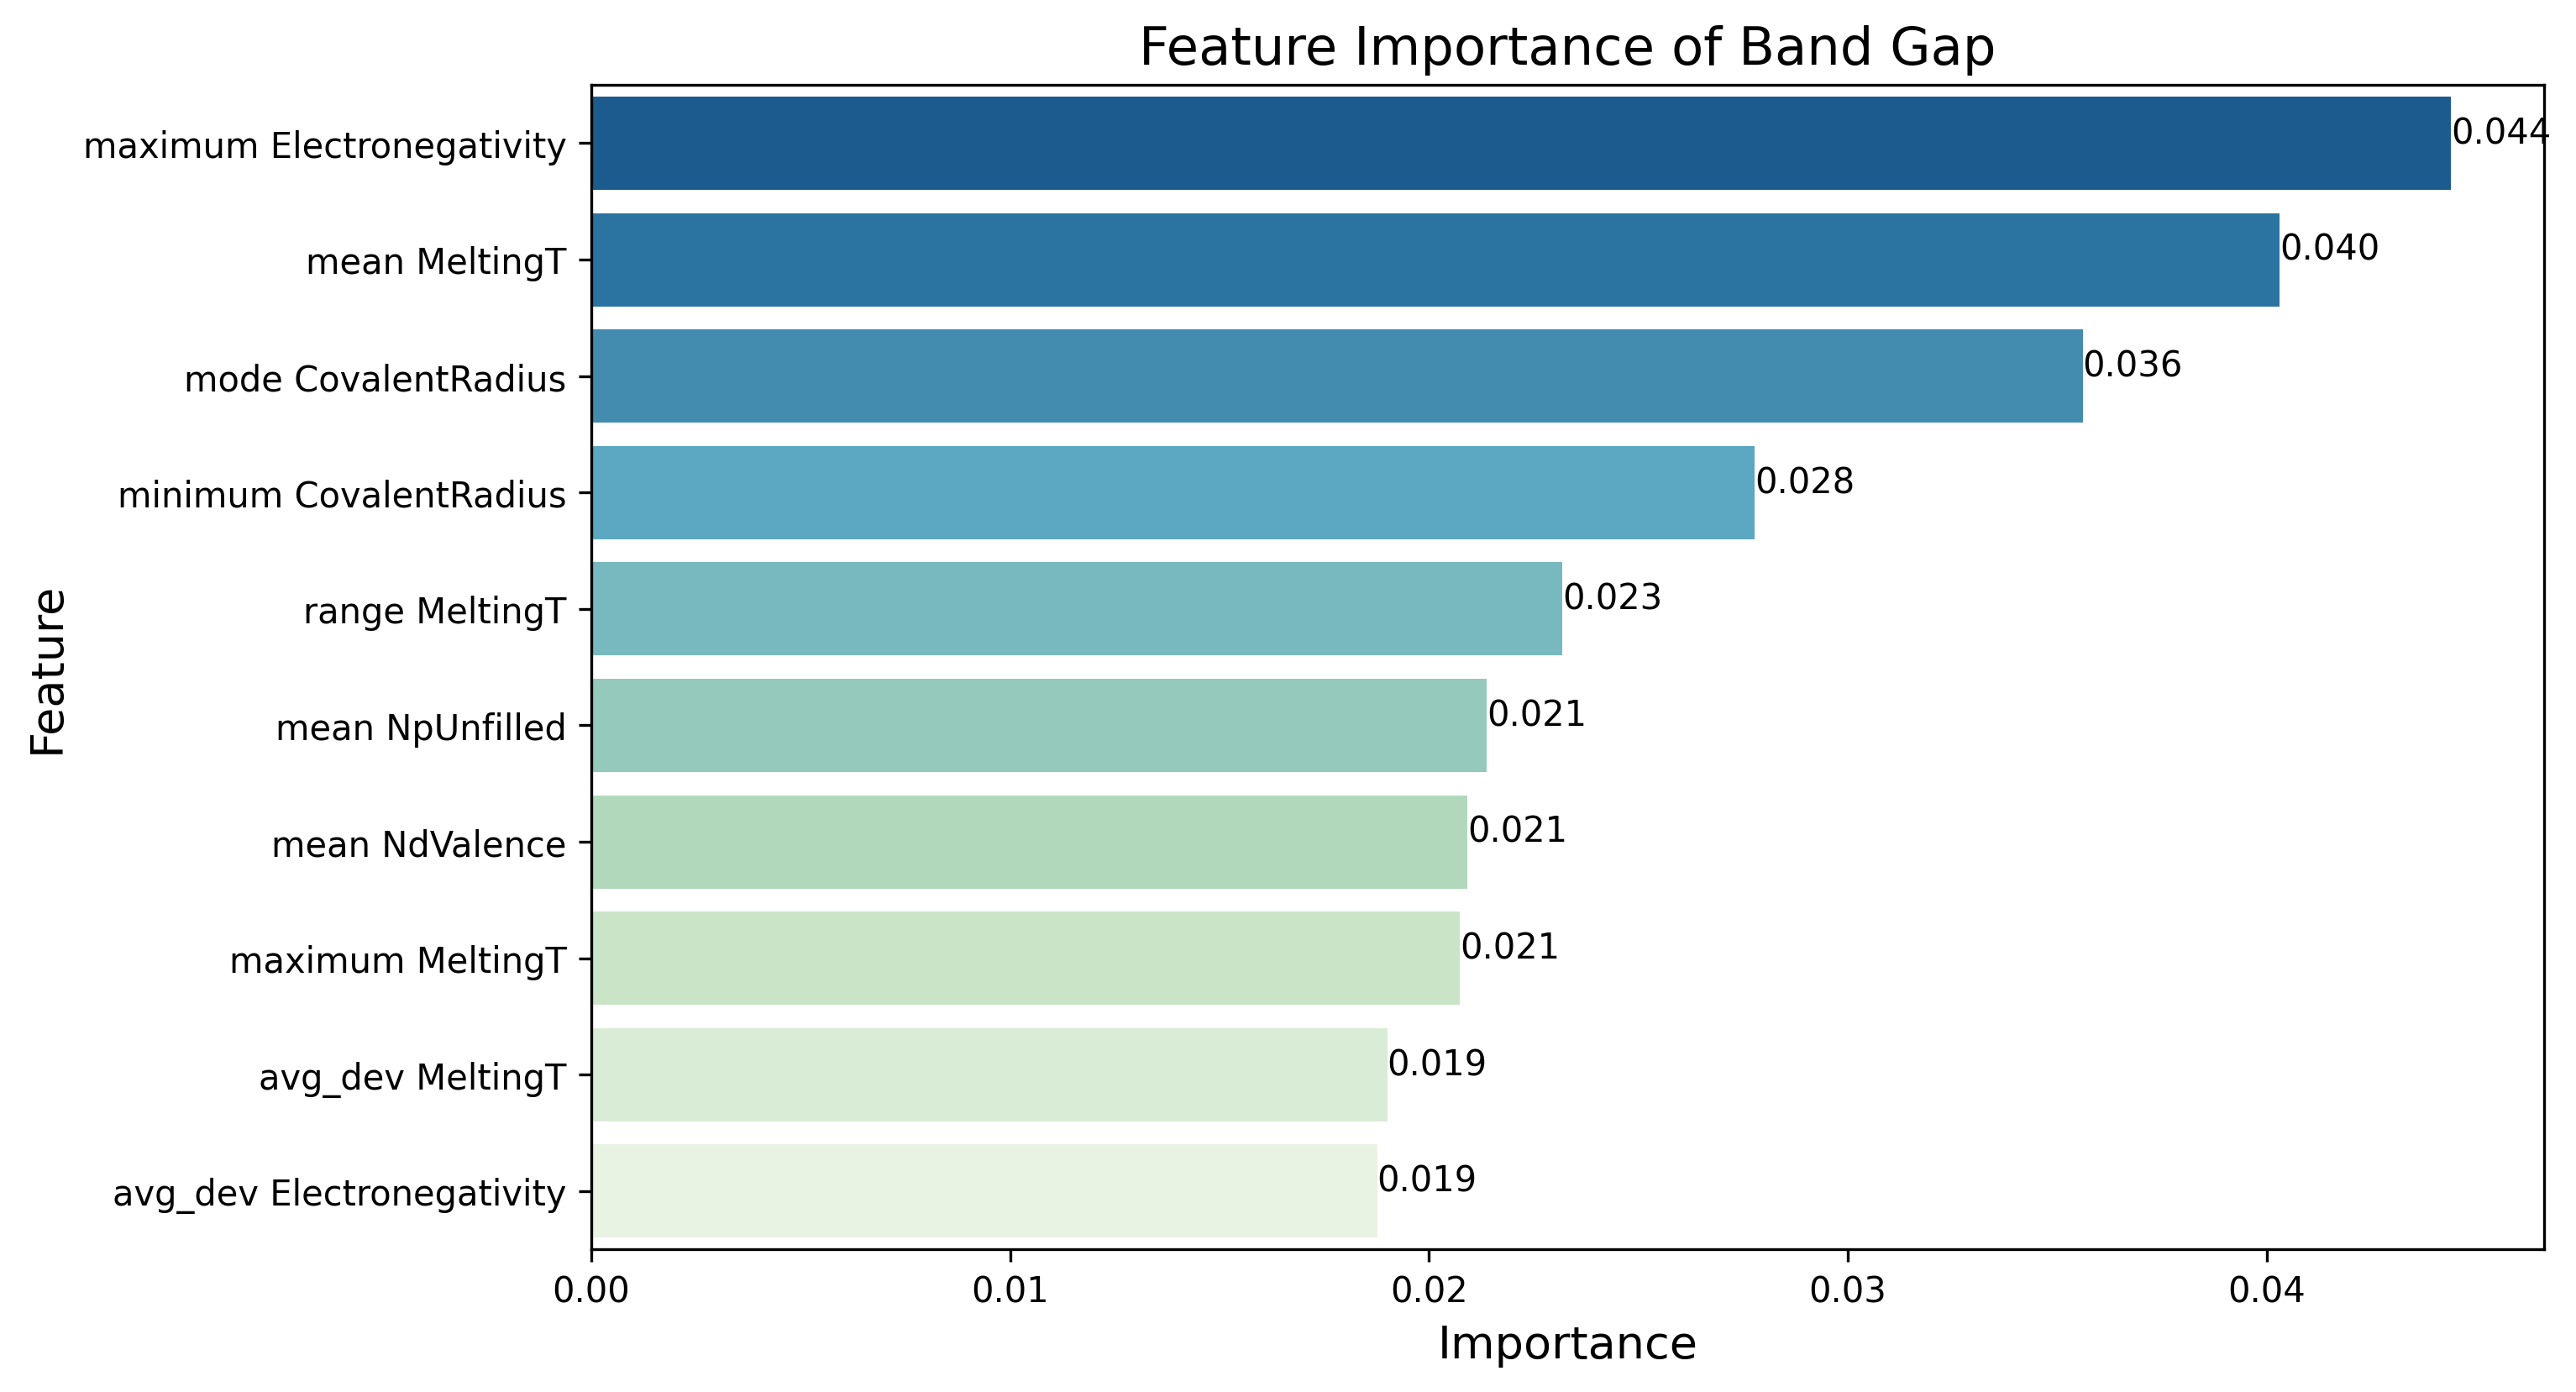

,Feature,Importance
1,maximum Electronegativity,0.044397
2,mean MeltingT,0.040305
0,mode CovalentRadius,0.035606
4,minimum CovalentRadius,0.027777
3,range MeltingT,0.023185
6,mean NpUnfilled,0.021375
9,mean NdValence,0.020924
5,maximum MeltingT,0.020745
7,avg_dev MeltingT,0.019005
12,avg_dev Electronegativity,0.018764


In [49]:
# 绘制特征重要性图
from Utools.draw import plot_feature_importance
plot_feature_importance(estimator_final, X_train_best.columns, top_n=10,
                            fig_path=os.path.join(fig_path, f'feature_importance.png'))


In [50]:
feature_importance_df.head(10)

,Feature,Importance
0,maximum Electronegativity,0.044397
1,mean MeltingT,0.040305
2,mode CovalentRadius,0.035606
3,minimum CovalentRadius,0.027777
4,range MeltingT,0.023185
5,mean NpUnfilled,0.021375
6,mean NdValence,0.020924
7,maximum MeltingT,0.020745
8,avg_dev MeltingT,0.019005
9,avg_dev Electronegativity,0.018764


In [51]:
selected_features[best_n_features - 1]

Index(['mode CovalentRadius', 'maximum Electronegativity', 'mean MeltingT',
       'range MeltingT', 'minimum CovalentRadius', 'maximum MeltingT',
       'mean NpUnfilled', 'avg_dev MeltingT', 'mean Electronegativity',
       'mean NdValence', 'mean SpaceGroupNumber', 'avg_dev SpaceGroupNumber',
       'avg_dev Electronegativity', 'avg_dev NValence', 'mean NUnfilled',
       'avg_dev NdValence', 'avg_dev NUnfilled', 'avg_dev Column',
       'mean GSbandgap', 'maximum MendeleevNumber', 'mean CovalentRadius',
       'avg_dev NpValence', 'avg_dev GSbandgap', 'mean NpValence',
       'maximum NUnfilled', 'avg_dev NpUnfilled', 'mean Row', 'mean NValence',
       'mean GSvolume_pa', 'avg_dev GSvolume_pa', 'mean MendeleevNumber',
       'mean AtomicWeight', 'minimum GSvolume_pa', 'avg_dev MendeleevNumber',
       'avg_dev CovalentRadius', 'mean Column', 'mean Number',
       'avg_dev Number', 'range Electronegativity', 'avg_dev AtomicWeight',
       'range MendeleevNumber', 'avg_dev Row', 'ra

In [52]:
# 保存RFE后的训练集和测试集
train_dir = os.path.join(current_path, 'Data', 'rfe_train_data')
test_dir = os.path.join(current_path, 'Data', 'rfe_test_data')  
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

drop_columns = dft_train.columns[~dft_train.columns.isin(list(best_features)+['composition', 'band_gap'])]
dft_train_rfe = dft_train.drop(columns=drop_columns)
dft_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mp_test_set.csv'))
dft_test_rfe = dft_test.drop(columns=drop_columns)

# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'exp_train_set.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'exp_test_set.csv'))
exp_train_rfe = exp_train.drop(columns=drop_columns)
exp_test_rfe = exp_test.drop(columns=drop_columns)
# mp plus data
mp_plus_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_plus_train_set.csv'))
mp_plus_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mp_plus_test_set.csv'))
mp_plus_train_rfe = mp_plus_train.drop(columns=drop_columns)
mp_plus_test_rfe = mp_plus_test.drop(columns=drop_columns)
# mix test 
mix_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mix_test_set.csv'))
mix_test_rfe = mix_test.drop(columns=drop_columns)


dft_train_rfe.to_csv(os.path.join(train_dir, 'mp_train_set.csv'), index=False)
dft_test_rfe.to_csv(os.path.join(test_dir, 'mp_test_set.csv'), index=False)
exp_train_rfe.to_csv(os.path.join(train_dir, 'exp_train_set.csv'), index=False) 
exp_test_rfe.to_csv(os.path.join(test_dir, 'exp_test_set.csv'), index=False)
mp_plus_train_rfe.to_csv(os.path.join(train_dir, 'mp_plus_train_set.csv'), index=False)
mp_plus_test_rfe.to_csv(os.path.join(test_dir, 'mp_plus_test_set.csv'), index=False)
mix_test_rfe.to_csv(os.path.join(test_dir, 'mix_test_set.csv'), index=False)


In [53]:
mp_plus_train_rfe.shape, mp_plus_test_rfe.shape

((8275, 90), (2067, 90))

In [54]:
dft_train_rfe.shape, dft_test_rfe.shape

((8275, 79), (2067, 79))

In [55]:
exp_train_rfe.shape, exp_test_rfe.shape

((2545, 79), (585, 79))

In [56]:
mix_test_rfe.shape

(1170, 79)